In [1]:
#Task 1
import cv2
import numpy as np

# Load Video
video_path = "vvi.mp4"
cap = cv2.VideoCapture(video_path)

# Initialize background subtractor
bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=50, detectShadows=True)

# Define the codec and create VideoWriter object to save output
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_tagged.avi', fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

# Define tracking parameters
tracking_objects = {}
object_id = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Apply background subtraction to detect moving objects
    fg_mask = bg_subtractor.apply(frame)
    _, fg_mask = cv2.threshold(fg_mask, 250, 255, cv2.THRESH_BINARY)  # Remove shadows
    fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))  # Reduce noise

    # Detect contours for moving objects
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Detect and initialize trackers for new objects
    for cnt in contours:
        if cv2.contourArea(cnt) < 500:  # Filter small objects
            continue
        x, y, w, h = cv2.boundingRect(cnt)

        # Extract features: color histogram and edge features
        roi = frame[y:y+h, x:x+w]
        color_hist = cv2.calcHist([roi], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        color_hist = cv2.normalize(color_hist, color_hist).flatten()

        # Initialize tracker if new object detected
        if object_id not in tracking_objects:
            tracker = cv2.legacy.TrackerMOSSE_create()
            tracking_objects[object_id] = tracker
            tracker.init(frame, (x, y, w, h))
            object_id += 1

    # Track and update positions
    to_delete = []  # Collect trackers to delete after iteration
    for obj_id, tracker in list(tracking_objects.items()):
        success, bbox = tracker.update(frame)
        if success:
            x, y, w, h = [int(v) for v in bbox]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(frame, f"Person {obj_id}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        else:
            to_delete.append(obj_id)  # Mark tracker for deletion if tracking fails

    # Delete trackers marked for removal
    for obj_id in to_delete:
        del tracking_objects[obj_id]

    # Save and display the output
    out.write(frame)
    cv2.imshow("Tagged Video", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

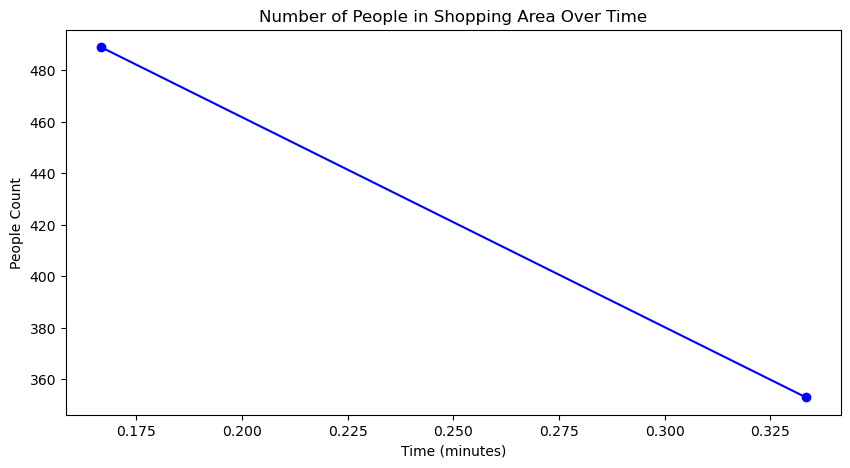

Peak interval at 0.16666666666666666 minutes with 489 people.


In [10]:
#Task 2
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np

# Initialize HOG descriptor/person detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Open video
cap = cv2.VideoCapture('vmart.mp4')

# Tracking parameters and data storage
frame_count = 0
interval_count = 0
people_counts = []
time_stamps = []
interval_duration = 10 * 25  # 10 seconds3e in terms of frames at 25 fps
tracker_type = "KCF"
unique_people_count = 0
trackers = []
tracked_positions = []

# Define function to add a new tracker
def create_tracker(tracker_type, frame, box):
    if tracker_type == "KCF":
        tracker = cv2.TrackerKCF_create()
    elif tracker_type == "CSRT":
        tracker = cv2.TrackerCSRT_create()
    tracker.init(frame, box)
    return tracker

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize frame for faster processing
    frame = imutils.resize(frame, width=min(400, frame.shape[1]))

    if frame_count % 30 == 0:  # Run detection every 30 frames
        # Detect people in frame
        (regions, _) = hog.detectMultiScale(frame, winStride=(8, 8), padding=(4, 4), scale=1.1)
        boxes = [(x, y, x + w, y + h) for (x, y, w, h) in regions]

        # Filter new detections to prevent duplicate tracking of the same person
        new_boxes = []
        for box in boxes:
            x, y, x2, y2 = box
            box_center = ((x + x2) // 2, (y + y2) // 2)

            # Check if the center of the box is too close to any tracked box center
            too_close = False
            for tracked_pos in tracked_positions:
                dist = np.sqrt((tracked_pos[0] - box_center[0]) ** 2 + (tracked_pos[1] - box_center[1]) ** 2)
                if dist < 50:  # Threshold distance to filter out duplicate detections
                    too_close = True
                    break

            # If not close to any existing tracked position, add it as a new person
            if not too_close:
                new_boxes.append((x, y, x2 - x, y2 - y))
                tracked_positions.append(box_center)  # Update tracked positions

        # Add new trackers for each detected person
        for box in new_boxes:
            tracker = create_tracker(tracker_type, frame, box)
            trackers.append(tracker)
            unique_people_count += 1  # Count new unique detection

    # Update all trackers and draw bounding boxes
    current_people_count = 0
    for tracker in trackers:
        success, box = tracker.update(frame)
        if success:
            p1 = (int(box[0]), int(box[1]))
            p2 = (int(box[0] + box[2]), int(box[1] + box[3]))
            cv2.rectangle(frame, p1, p2, (0, 255, 0), 2, 1)
            current_people_count += 1

    # Update interval count
    interval_count += current_people_count
    frame_count += 1

    # Show frame
    cv2.imshow("People Detection", frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    # Record count every interval
    if frame_count % interval_duration == 0:
        time_stamps.append(frame_count / (25 * 60))  # Timestamp in minutes
        people_counts.append(interval_count)
        interval_count = 0  # Reset interval count

cap.release()
cv2.destroyAllWindows()

# Plotting number of people over time
plt.figure(figsize=(10, 5))
plt.plot(time_stamps, people_counts, marker='o', color='b')
plt.title("Number of People in Shopping Area Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("People Count")
plt.show()

# Display peak interval information
peak_count = max(people_counts)
peak_interval = time_stamps[people_counts.index(peak_count)]
print(f"Peak interval at {peak_interval} minutes with {peak_count} people.")

In [3]:
#Task 3
import cv2
import numpy as np

# Load Reference Image
reference_image_path = "ref.jpg"
reference_image = cv2.imread(reference_image_path)
gray_reference = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)

# Load Video
video_path = "suspect.mp4"
cap = cv2.VideoCapture(video_path)

# Haar Cascade for Face Detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect the reference face and extract features
reference_faces = face_cascade.detectMultiScale(gray_reference, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
if len(reference_faces) == 0:
    print("No face detected in the reference image.")
    exit()

(x, y, w, h) = reference_faces[0]
reference_face = gray_reference[y:y+h, x:x+w]

# Apply edge detection on the reference face for feature extraction
reference_edges = cv2.Canny(reference_face, 100, 200)

# Function to compare two faces using structural similarity
def is_match(face1, face2):
    face1_resized = cv2.resize(face1, (face2.shape[1], face2.shape[0]))  # Resize for direct comparison
    difference = cv2.absdiff(face1_resized, face2)
    _, thresh_diff = cv2.threshold(difference, 50, 255, cv2.THRESH_BINARY)
    similarity = 1 - np.sum(thresh_diff) / (face2.shape[0] * face2.shape[1] * 255)
    return similarity > 0.7  # Adjust threshold based on testing

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in each frame
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        detected_face = gray_frame[y:y+h, x:x+w]
        detected_edges = cv2.Canny(detected_face, 100, 200)
        
        # Compare features with the reference face
        if is_match(reference_edges, detected_edges):
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, "Match Found", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.imshow("Matched Frame", frame)
            cv2.waitKey(3000)  # Display the matched frame for 3 seconds

    cv2.imshow("Video Stream", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [19]:
#Task 4
import cv2
import numpy as np

# Load Video
video_path = "store.mp4"
cap = cv2.VideoCapture(video_path)

# Define region of interest (ROI) for entrance
roi_line_y = 300  # Adjust this based on the video frame where the entrance is located

# Background Subtractor for motion detection
bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=25, detectShadows=True)

# Counters for entering and exiting
enter_count = 0
exit_count = 0

# Flag to track direction of movement
people_positions = {}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale for processing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply background subtraction
    fg_mask = bg_subtractor.apply(gray)
    _, fg_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)  # Apply threshold to remove shadows
    fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))  # Remove noise

    # Detect contours to identify people
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Track people based on contours
    current_positions = {}
    for cnt in contours:
        if cv2.contourArea(cnt) < 800:  # Filter small areas
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        cx, cy = x + w // 2, y + h // 2

        # Draw bounding box and center point
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1)

        # Check if the person is crossing the ROI line
        current_positions[cx] = cy

        # If a new person crosses the line downward (entering)
        if cx in people_positions:
            prev_y = people_positions[cx]
            if prev_y < roi_line_y and cy >= roi_line_y:
                enter_count += 1
                print(f"Person entered: {enter_count}")
            elif prev_y > roi_line_y and cy <= roi_line_y:
                exit_count += 1
                print(f"Person exited: {exit_count}")

    # Update tracked positions
    people_positions = current_positions

    # Draw the ROI line
    cv2.line(frame, (0, roi_line_y), (frame.shape[1], roi_line_y), (255, 0, 0), 2)
    cv2.putText(frame, f"Entered: {enter_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    cv2.putText(frame, f"Exited: {exit_count}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # Display the frame
    cv2.imshow("People Counting", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

# Final result
print(f"Total Entered: {enter_count}")
print(f"Total Exited: {exit_count}")

Person entered: 1
Person exited: 1
Person exited: 2
Person exited: 3
Person entered: 2
Person entered: 3
Total Entered: 3
Total Exited: 3


In [5]:
#Task 5
import cv2
import numpy as np
import time

# Load Video
video_path = "store.mp4"  # Replace with the actual path to your video
cap = cv2.VideoCapture(video_path)

# Define ROI for dwelling time calculation (adjust these coordinates as needed)
roi_x, roi_y, roi_w, roi_h = 200, 150, 300, 300  # Example coordinates for the ROI

# Initialize background subtractor
bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=25, detectShadows=True)

# Dictionary to store entry time for each person
dwell_times = {}

# Track unique IDs for each detected person
person_id_counter = 0
tracked_objects = {}

# Define time threshold to display dwell time in seconds
time_threshold = 1  # Adjust as needed

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply background subtraction
    fg_mask = bg_subtractor.apply(gray)
    _, fg_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
    fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))

    # Detect contours
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Track objects in the ROI
    current_frame_objects = []
    for cnt in contours:
        if cv2.contourArea(cnt) < 800:
            continue

        x, y, w, h = cv2.boundingRect(cnt)
        cx, cy = x + w // 2, y + h // 2

        # Check if the center of the object is within the ROI
        if roi_x <= cx <= roi_x + roi_w and roi_y <= cy <= roi_y + roi_h:
            current_frame_objects.append((cx, cy))
            match_found = False

            # Match current object to a tracked one
            for obj_id, obj_info in tracked_objects.items():
                if np.hypot(obj_info['position'][0] - cx, obj_info['position'][1] - cy) < 50:
                    tracked_objects[obj_id]['position'] = (cx, cy)
                    match_found = True
                    break

            # If no match found, assign new ID and start tracking
            if not match_found:
                tracked_objects[person_id_counter] = {'position': (cx, cy), 'entry_time': time.time()}
                person_id_counter += 1

    # Update and calculate dwell time
    for obj_id, obj_info in list(tracked_objects.items()):
        cx, cy = obj_info['position']
        if roi_x <= cx <= roi_x + roi_w and roi_y <= cy <= roi_y + roi_h:
            dwell_time = time.time() - obj_info['entry_time']
            if dwell_time > time_threshold:
                dwell_times[obj_id] = dwell_time
        else:
            del tracked_objects[obj_id]  # Remove if object is outside ROI

    # Draw ROI on the frame
    cv2.rectangle(frame, (roi_x, roi_y), (roi_x + roi_w, roi_y + roi_h), (255, 0, 0), 2)
    cv2.putText(frame, "ROI", (roi_x, roi_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Display each person's dwell time in the ROI
    for obj_id, dwell_time in dwell_times.items():
        cv2.putText(frame, f"ID {obj_id}: {dwell_time:.1f}s", (10, 30 + 30 * obj_id),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Show frame
    cv2.imshow("Dwell Time", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

# Final Results
print("Dwell Times:")
for obj_id, dwell_time in dwell_times.items():
    print(f"Person ID {obj_id} dwelled for {dwell_time:.1f} seconds")

Dwell Times:
Person ID 0 dwelled for 3.3 seconds
Person ID 1 dwelled for 3.3 seconds
Person ID 2 dwelled for 3.2 seconds
Person ID 3 dwelled for 3.2 seconds
Person ID 4 dwelled for 3.2 seconds
Person ID 5 dwelled for 3.1 seconds
Person ID 6 dwelled for 3.0 seconds
Person ID 7 dwelled for 3.0 seconds
Person ID 8 dwelled for 3.0 seconds
Person ID 9 dwelled for 2.9 seconds
Person ID 10 dwelled for 2.9 seconds
Person ID 11 dwelled for 2.9 seconds
Person ID 12 dwelled for 2.9 seconds
Person ID 13 dwelled for 2.9 seconds
Person ID 14 dwelled for 2.6 seconds
Person ID 15 dwelled for 2.4 seconds
Person ID 16 dwelled for 2.3 seconds
Person ID 17 dwelled for 2.2 seconds
Person ID 18 dwelled for 2.0 seconds
Person ID 19 dwelled for 1.9 seconds
Person ID 20 dwelled for 1.7 seconds
Person ID 21 dwelled for 1.3 seconds


In [1]:
#task 6
import cv2
import numpy as np

# Function to detect cars based on color (adjust the color range for different car colors)
def detect_cars_by_color(frame, lower_color, upper_color):
    # Convert frame to HSV color space for better color detection
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Create a mask for the color range
    mask = cv2.inRange(hsv_frame, lower_color, upper_color)
    
    # Bitwise AND to isolate the colored regions
    colored_cars = cv2.bitwise_and(frame, frame, mask=mask)
    
    return colored_cars, mask

# Load the video
video_path = 'bb.mp4'
cap = cv2.VideoCapture(video_path)

# Variables for counting the cars
car_count = 0
frame_number = 0

# Define color ranges for detection (example: red cars)
# You can add multiple color ranges for different brands (e.g., blue, yellow)
red_lower = np.array([0, 120, 70])  # Lower bound for red in HSV
red_upper = np.array([10, 255, 255])  # Upper bound for red in HSV

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Detect cars of a specific color (red in this example)
    colored_cars, mask = detect_cars_by_color(frame, red_lower, red_upper)
    
    # Apply background subtraction (optional, depends on motion detection requirements)
    fg_mask = cv2.createBackgroundSubtractorMOG2().apply(frame)
    fg_mask = cv2.bitwise_and(fg_mask, fg_mask, mask=mask)  # Combine motion and color detection

    # Find contours in the foreground mask to detect moving cars
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Filter out small contours (noise)
            x, y, w, h = cv2.boundingRect(contour)
            # Draw rectangle around detected car
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            car_count += 1  # Increment car count

    # Display the frame with detected cars
    cv2.putText(frame, f'Total Cars Detected: {car_count}', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Car Detection', frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_number += 1

# Release the video capture and close all windows
cap.release()
cv2.destroyAllWindows()

# Output the total count of cars
print(f'Total cars detected: {car_count}')

Total cars detected: 117
